<a href="https://colab.research.google.com/github/AbiXnash/HGCNN-LSTM-A-Data-driven-Approach-for-Cyber-Attack-Detection-in-Cyber-Physical-Systems/blob/main/SWAT_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import required packages
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv1D, Dropout
from keras.optimizers import SGD

# from keras.utils import np_utils
import csv
from sklearn import preprocessing
from numpy import linalg as LA
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import time

In [ ]:
# Load data
datafile = open('/content/drive/MyDrive/Colab Notebooks/SWaT_Dataset_Attack_v0.csv', 'r')
datareader = csv.reader(datafile, delimiter=',')
data = []
label = []

In [ ]:
# Extract even number of Normal and Attack samples with labels as binary classes
for row in datareader:
    if 'Normal' in row:
        data.append(row[2:-1])
        label.append(0)
    if 'Attack' in row:
        data.append(row[2:-1])
        label.append(1)

In [ ]:
features = len(data[0])

In [ ]:
# Convert the list to numpy array of float type
dataset = np.array(data).astype(float)
label = np.array(label).astype(float)

In [ ]:
# Undersample the dataset to balance classes
dataset, label = RandomUnderSampler(random_state=42).fit_resample(dataset, label)

In [ ]:
# Standardize the dataset
dataset = preprocessing.scale(dataset)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:259: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


In [ ]:
# Perform PCA dimensionality reduction
cov_matrix = np.cov(dataset, rowvar=False)
eigenvalues, eigenvectors = LA.eig(cov_matrix)
V = eigenvectors[:, 1:]  # Exclude the eigenvector with zero eigenvalue
print("\nPCA eliminated features:", 1, "\n")
reduced_data = np.matmul(V.T, dataset.T).T


PCA eliminated features: 1 



In [ ]:
# Standardize the reduced dataset
reduced_data = preprocessing.scale(reduced_data)

In [ ]:
# Split the data into train and test sets
train_data, test_data, train_label, test_label = train_test_split(reduced_data, label, test_size=0.2, shuffle=True)

In [ ]:
# Reshape data for CNN
train_x = train_data[:, :, np.newaxis]
test_x = test_data[:, :, np.newaxis]

In [ ]:
# Set model parameters
lr1, decay1, dp, mom = 0.5, 0.33, 0.03, 0.5
nb_class = 2
nb_epoch = 50

In [ ]:
from keras.utils import to_categorical

# Convert labels to categorical
train_y = to_categorical(train_label, nb_class)
test_y = to_categorical(test_label, nb_class)

In [ ]:
from keras.layers import Conv1D

# Build CNN model
model = Sequential()
model.add(Conv1D(filters=features-1, kernel_size=1, input_shape=(features-1, 1)))
model.add(Activation('tanh'))
model.add(Flatten())
model.add(Dropout(dp))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dropout(dp))
model.add(Dense(50, activation='relu'))
model.add(Dense(nb_class))
model.add(Activation('softmax'))

In [ ]:
from keras.optimizers import SGD

# Compile the model
sgd = SGD(learning_rate=lr1, momentum=mom, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc', 'mse'])


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 49, 49)            98        
                                                                 
 activation_1 (Activation)   (None, 49, 49)            0         
                                                                 
 flatten_1 (Flatten)         (None, 2401)              0         
                                                                 
 dropout (Dropout)           (None, 2401)              0         
                                                                 
 dense (Dense)               (None, 200)               480400    
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dropout_1 (Dropout)         (None, 100)              

In [ ]:
# Train the model
t1 = time.time()
history = model.fit(train_x, train_y, validation_split=0.2, epochs=nb_epoch, batch_size=256)
t2 = time.time()
print("Time:", t2-t1)

Epoch 1/50
273/273 [==============================] - 7s 22ms/step - loss: 0.1001 - acc: 0.9586 - mse: 0.0295 - val_loss: 0.0458 - val_acc: 0.9833 - val_mse: 0.0126
Epoch 2/50
273/273 [==============================] - 6s 22ms/step - loss: 0.0399 - acc: 0.9852 - mse: 0.0110 - val_loss: 0.0437 - val_acc: 0.9815 - val_mse: 0.0131
Epoch 3/50
273/273 [==============================] - 6s 21ms/step - loss: 0.0291 - acc: 0.9894 - mse: 0.0081 - val_loss: 0.0267 - val_acc: 0.9900 - val_mse: 0.0076
Epoch 4/50
273/273 [==============================] - 6s 21ms/step - loss: 0.0246 - acc: 0.9911 - mse: 0.0068 - val_loss: 0.0199 - val_acc: 0.9937 - val_mse: 0.0052
Epoch 5/50
273/273 [==============================] - 6s 22ms/step - loss: 0.0202 - acc: 0.9927 - mse: 0.0055 - val_loss: 0.0213 - val_acc: 0.9928 - val_mse: 0.0054
Epoch 6/50
273/273 [==============================] - 6s 21ms/step - loss: 0.0180 - acc: 0.9935 - mse: 0.0050 - val_loss: 0.0175 - val_acc: 0.9935 - val_mse: 0.0049
Epoch 7/50

In [ ]:
# Function to test model
def test_results(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    mat = confusion_matrix(true_class, predicted_class)
    tp, fn, fp, tn = mat.ravel()
    print("\nConfusion Matrix:\n")
    print("TP=", tp, "|", "TN=", tn)
    print("--------------------")
    print("FP=", fp, "   |", "FN=", fn)
    a = accuracy_score(true_class, predicted_class)
    print("\nAccuracy score is", a)
    D_rate = tp / (tp + fn)
    print("\nDetection rate:", round(D_rate, 4))
    FA_rate = fp / (tn + fp) if (tn + fp) != 0 else 1.0
    print("\nFalse alarm rate:", round(FA_rate, 4))
    prc, rcl, fsc, sup = precision_recall_fscore_support(true_class, predicted_class, pos_label=0, average='binary')
    print("\nPrecision:", prc)
    print("\nRecall:", rcl)
    print("\nF-score:", fsc)

In [ ]:
# Test the model
test_results(test_x, test_y, model)

683/683 [==============================] - 1s 2ms/step

Confusion Matrix:

TP= 10845 | TN= 10856
--------------------
FP= 51    | FN= 82

Accuracy score is 0.9939085829440323

Detection rate: 0.9925

False alarm rate: 0.0047

Precision: 0.9953193832599119

Recall: 0.9924956529697081

F-score: 0.9939055125326489


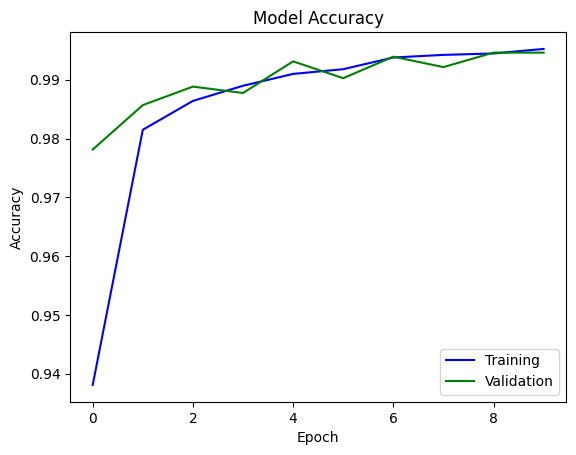

In [ ]:
# Plot accuracy and mean squared error
plt.plot(history.history['acc'], color='blue')
plt.plot(history.history['val_acc'], color='green')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

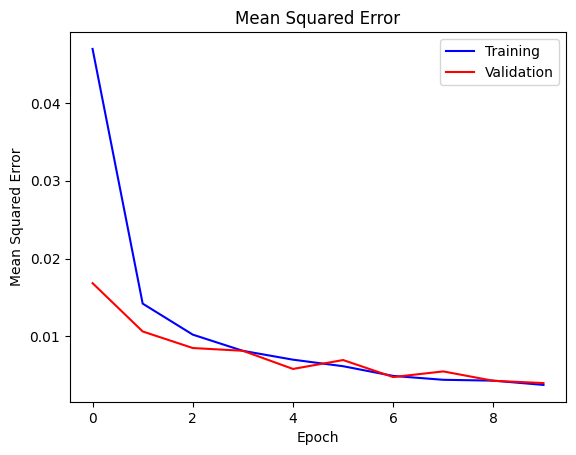

In [ ]:
plt.plot(history.history['mse'], color='blue')
plt.plot(history.history['val_mse'], color='red')
plt.title('Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()